# Natural Language Processing - Knowledge Graph example

###### Links: [CNN DailyMail (HuggingFace)](https://huggingface.co/datasets/cnn_dailymail)  |  [Article (TowardsDataScience)](https://towardsdatascience.com/text-summarization-with-nlp-textrank-vs-seq2seq-vs-bart-474943efeb09)

### 0 - Setup

###### Import pckgs

In [40]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for text
import wikipediaapi
import nltk
import re
import contractions

## for nlp
import spacy
from spacy import displacy

###### Import data

In [2]:
wiki = wikipediaapi.Wikipedia('en')
page = wiki.page("History_of_Rome")
original_txt = page.text[:page.text.find("See also")]
original_txt

'The history of Rome includes the history of the city of Rome as well as the civilisation of ancient Rome. Roman history has been influential on the modern world, especially in the history of the Catholic Church, and Roman law has influenced many modern legal systems. Roman history can be divided into the following periods:\n\nPre-historical and early Rome, covering Rome\'s earliest inhabitants and the legend of its founding by Romulus\nThe period of Etruscan dominance and the regal period, in which, according to tradition, Romulus was the first of seven kings\nThe Roman Republic, which commenced in 509 BCE when kings were replaced with rule by elected magistrates. The period was marked by vast expansion of Roman territory. During the 5th century BCE, Rome gained regional dominance in Latium. With the Punic Wars from 264 to 146 BCE, ancient Rome gained dominance over the Western Mediterranean, displacing Carthage as the dominant regional power.\nThe Roman Empire followed the Republic, 

###### Text cleaning

In [3]:
'''
Creates a list of stopwords.
:parameter
    :param lst_langs: list - ["english", "italian"]
    :param lst_add_words: list - list of new stopwords to add
    :param lst_keep_words: list - list words to keep (exclude from stopwords)
:return
    stop_words: list of stop words
'''      
def create_stopwords(lst_langs=["english"], lst_add_words=[], lst_keep_words=[]):
    lst_stopwords = set()
    for lang in lst_langs:
        lst_stopwords = lst_stopwords.union( set(nltk.corpus.stopwords.words(lang)) )
    lst_stopwords = lst_stopwords.union(lst_add_words)
    lst_stopwords = list(set(lst_stopwords) - set(lst_keep_words))
    return sorted(list(set(lst_stopwords)))

In [4]:
lst_stopwords = create_stopwords(lst_add_words=[], lst_keep_words=[])
print(lst_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

In [5]:
'''
Preprocess a string.
:parameter
    :param txt: string - name of column containing text
    :param dic_regex: dict - regex to replace
    :param punkt: bool - if True removes punctuations and characters
    :param lower: bool - if True convert lowercase
    :param slang: bool - if True fix slang into normal words
    :param lst_stopwords: list - list of stopwords to remove
    :param stemm: bool - whether stemming is to be applied
    :param lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(txt, dic_regex=None, punkt=True, lower=True, slang=True, lst_stopwords=None, 
                          stemm=False, lemm=True):
    ## Regex (in case, before cleaning)
    if dic_regex is not None: 
        for k,v in dic_regex.items():
            txt = re.sub(k, v, txt)

    ## Clean 
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt
    ### slang
    txt = contractions.fix(txt) if slang is True else txt
            
    ## Tokenize (convert from string to list)
    lst_txt = txt.split()
                
    ## Stemming (remove -ing, -ly, ...)
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
                
    ## Lemmatization (convert the word into root word)
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]

    ## Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in lst_stopwords]
            
    ## Back to string
    txt = " ".join(lst_txt)
    return txt

In [31]:
txt = utils_preprocess_text(original_txt, dic_regex={"-":" "}, punkt=True, lower=False, slang=False, 
                            lst_stopwords=lst_stopwords, stemm=False, lemm=False)
txt = original_txt

In [32]:
'''
Compute n-grams frequency with nltk tokenizer.
:parameter
    :param txt: text
    :param ngrams: int or list - 1 for unigrams, 2 for bigrams, [1,2] for both
    :param top: num - plot the top frequent words
:return
    dtf_count: dtf with word frequency
'''
def word_freq(txt, ngrams=[1,2,3], top=10, figsize=(10,7)):
    lst_tokens = nltk.tokenize.word_tokenize(txt)
    ngrams = [ngrams] if type(ngrams) is int else ngrams
    
    ## calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq = dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return dtf_freq

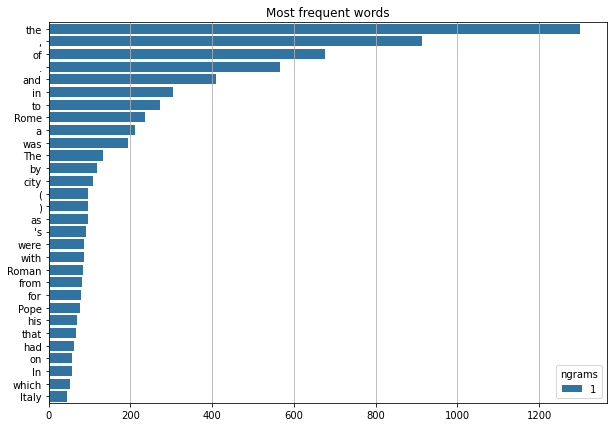

In [33]:
# Find most common words in text
_ = word_freq(txt, ngrams=[1], top=30, figsize=(10,7))

### 1 - NLP

###### Model

In [34]:
#python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
doc = nlp(txt)

###### Sentence Segmentation

In [92]:
lst_txt = [sent for sent in doc.sents]
for i in lst_txt:
    print(i, "\n---")

The history of Rome includes the history of the city of Rome as well as the civilisation of ancient Rome. 
---
Roman history has been influential on the modern world, especially in the history of the Catholic Church, and Roman law has influenced many modern legal systems. 
---
Roman history can be divided into the following periods:

Pre-historical and early Rome, covering Rome's earliest inhabitants and the legend of its founding by Romulus
The period of Etruscan dominance and the regal period, in which, according to tradition, Romulus was the first of seven kings
The Roman Republic, which commenced in 509 BCE when kings were replaced with rule by elected magistrates. 
---
The period was marked by vast expansion of Roman territory. 
---
During the 5th century BCE, Rome gained regional dominance in Latium. 
---
With the Punic Wars from 264 to 146 BCE, ancient Rome gained dominance over the Western Mediterranean, displacing Carthage as the dominant regional power.
 
---
The Roman Empire

###### Entity Extraction

In [99]:
i = 1
print(lst_txt[i], "\n---")

for tok in lst_txt[i]:
    print(tok.text, "...", tok.dep_)

Roman history has been influential on the modern world, especially in the history of the Catholic Church, and Roman law has influenced many modern legal systems. 
---
Roman ... amod
history ... nsubj
has ... aux
been ... ROOT
influential ... acomp
on ... prep
the ... det
modern ... amod
world ... pobj
, ... punct
especially ... advmod
in ... prep
the ... det
history ... pobj
of ... prep
the ... det
Catholic ... compound
Church ... pobj
, ... punct
and ... cc
Roman ... amod
law ... nsubj
has ... aux
influenced ... conj
many ... amod
modern ... amod
legal ... amod
systems ... dobj
. ... punct


In [100]:
displacy.render(lst_text[i], style="dep", options={"distance":150})

In [105]:
def get_entities(lst_txt):
    a, b, last_tag, last_token, current_token, modifier = "", "", "", "", "", ""
    for i in lst_txt:
        if i.dep_ != "punct":
            
            ## if compound --> current + last compound
            if i.dep_ == "compound":
                current_token = i.text
                if last_tag == "compound":
                    current_token = last_token + " " + i.text

            ## if modifier --> current + last compound
            if i.dep_.endswith("mod") is True:
                modifier = i.text
                if last_tag == "compound":
                    modifier = last_token + " " + i.text

            ## if subject --> entity A
            if i.dep_.find("subj") is True:
                a = modifier + " " + current_token + " " + i.text
                current_token, modifier, last_tag, last_token  = "", "", "", ""

            ## if object --> entity B
            if i.dep_.find("obj") is True:
                b = modifier + " " + current_token + " " + i.text

            ## update variables
            last_tag = i.dep_
            last_token = i.text
            
    return (a.strip(), b.strip())

In [106]:
get_entities(lst_txt[i])

amod
nsubj
aux
ROOT
acomp
prep
det
amod
pobj
punct
advmod
prep
det
pobj
prep
det
compound
pobj
punct
cc
amod
nsubj
aux
conj
amod
amod
amod
dobj
punct


('', '')

In [97]:
ents = [get_entities(i) for i in lst_txt]
ents

[('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),
 ('', ''),

###### Relation Extraction

### 2 - Network Graph